# Project ML for portfolio management


4 : results : explain what we’re doing and 
Summary of our test / empirical result. Can be positive or negative. 
5 : did it work or not, what can be improved / added ?

1. Introduction
1. Dataset overview
1. Analytics and learning strategies
1. Empirical resuts: baseline and robustness 
1. Conclusion

if you need to add any package, no problem: add cells in your notebook with "pip install my_additional_package" so that I'm aware of what additional packages I need to run your notebook. 
if you use data that you scrapped online, just provide the code to programmatically scrape the data. More generally, I don't want to receive data.csv files. 
if you use .py files to tidy your project, just use a %%writefile magic in the notebook -- so that on my side, I can create the same .py files on the fly. I don't want to receive additional .py files.

In [ ]:
# pip install selenium
# pip install pyLDAvis
# pip install pyLDAvis
# pip install fitz
# pip install frontend
# pip install berttopic

# ADDITIONAL PACKAGES
# pip install pdf_plumber
# pip install seaborn
# pip install plotly
# pip install wordcloud
# pip install nltk
# pip install tf-keras
# pip install gensim
# pip install numpy==1.24.6
# pip install spacy

In [ ]:
# MAIN IMPORTS
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
from pathlib import Path
import logging
import numpy as np 
import warnings
import pprint
from collections import Counter
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import pdfplumber  # For parsing PDF files
from io import BytesIO

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppress SettingWithCopyWarning
# pd.set_option('mode.chained_assignment', None)
# warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

### INTRODUCTION

Central bank speeches are a critical medium for conveying monetary policy intentions and market expectations, as well as communicating economic insights. The content and tone of these speeches can influence public perception and financial markets. However, limited research has been done to explore how these dynamics vary across gender, among central bank speakers. The aim of this project is to help fill this gap by investigating whether male and female central bank leaders differ in their communication styles using NLP techniques, focusing on the topics they address (topic modeling) and the tone of their speeches (sentiment analysis).

To conduct this analysis, we compiled a dataset of speeches delivered by central bank Governors and senior central bankers, published by the Bank for International Settlements. We filtered these speeches according to the institutions, keeping only those from European Central Banks. Using a combination of sentiment analysis and topic modeling, we systematically compared speech characteristics across genders.


Our findings suggest subtle differences in the tone and topics of speeches delivered by male and female central bank leaders. While sentiment analysis indicates that men exhibit slightly higher medians for both positive and negative sentiment scores, these differences are not pronounced. Moreover, few algorithms allow for sentiment analysis on large texts, and the few that do - Longformer for instance with a max input of 4096 tokens (versus 512 for most others) takes a very long time to run on our dataset, especially without a GPU (*I tried running it to compare /better our results but I didn't have the computational ressources necessary for the task*). \
Topic modeling reveals overlapping themes across genders, however, while male and female central bank leaders often address similar topics, there are some differences in the emphasis placed on certain themes
These results, while not groundbreaking, highlight the complexity of quantifying gendered communication styles in this domain and underscore the need for further research.

The inspiration for this project stems from the paper "Leadership, Gender, and Discourse in Monetary Policy: Analyzing Speech Dynamics in the FOMC" (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5002334). We applied similar methodologies to a novel dataset of European central bank speeches. Key resources include NLP libraries such as gensim, nltk and scikit-learn, as well as sentiment lexicons like Loughran-McDonald. The dataset of speeches and metadata was created through web scraping the BIS website, requesting the BIS API, and then enriched using the genderize.io API for speaker gender identification. \
Other reference that was used : Information in Central Bank Sentiment: An Analysis of Fed and ECB Communication (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4797935).

---------

### DATASET OVERVIEW

The dataset is composed of all central bankers' speeches avilable on the BIS website, coming from european central banks institutions. The speeches date from 2009 up until 2024.
The data was requested through the BIS API and the speeches themselves were scrapped from the individual BIS speeches html pages. \
/!\ *the data collecting function takes a while to run as there are about 20000 speeches on the BIS website that are then filtered and scrapped* \
The *get_central_bank_speeches_urls* function requests all speeches individual urls and the *load_central_banks_speeches* requests all speeches metadata information and then scrapes the speeches content from the html pages if the filter of the institution correponds.\
The gender information is added through requesting the genderize.io API. (a mapping dictionary is also provided in case the API request doesn't go through)

--------

#### Build the dataset

In [ ]:
def get_central_bank_speeches_urls():
    '''
    '''
    url = "https://www.bis.org/api/document_lists/cbspeeches.json"
    reviews=[]
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        speeches = response.json()
        # Get the list of speeches ids ,
        for review in speeches['list']:
            reviews.append(review)
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
    
    return(reviews)

review_urls = get_central_bank_speeches_urls()
print(f'There are a total of {len(review_urls)} central bank speeches available.')

There are a total of 20140 central bank speeches available.


In [59]:
logger = logging.getLogger(__name__)

def clean_directory_path(cache_dir, default_dir="data"):
    if cache_dir is None:
        cache_dir = Path(os.getcwd()) / default_dir
    if isinstance(cache_dir, str):
        cache_dir = Path(cache_dir)
    if not cache_dir.is_dir():
        os.makedirs(cache_dir)
    return cache_dir

In [ ]:
def load_central_banks_speeches_pdf(cache_dir="data", force_reload=False, progress_bar=False, institutions_filter=[6]):
    """
    """
    filename = clean_directory_path(cache_dir) / "central_banks_speeches_pdf.parquet"
    # load from cache if it exists and not force_reload
    if (filename.exists()) and not force_reload:
        logger.info(f"loading from cache file: {filename}")
        speeches = pd.read_parquet(filename)
    else:
        logger.info("loading from external source")

        # get all speeches URLs
        urls = get_central_bank_speeches_urls()
        if progress_bar:
            review_urls_ = tqdm(urls)
        else:
            review_urls_ = urls

        # get speeches metadata + extract / scrape speech from html page
        all_speeches = []
        base_url_api = "https://www.bis.org/api/documents"
        base_url = "https://www.bis.org"

        # iterate over speeches URLs
        counter=0
        switch=None
        for link in review_urls_ : #tqdm(reviews):
            counter+=1
            speech_data = {}
            review_url = f'{base_url_api}{link}.json'
            # speech_url = f'{base_url}{link}.htm'
            speech_pdf = f'{base_url}{link}.pdf'
            print(f"Processing speech: {review_url}")

            try:
                # Fetch speech page
                review_response = requests.get(review_url)
                review_metadata = review_response.json()
                speech_data.update(review_metadata)

                # Check if 'institutions' exists, skip processing if not
                    # only scrape speech if it's the right institution (filtering before scraping)  
                if 'institutions' in speech_data and any(inst in speech_data['institutions'] for inst in institutions_filter) : #speech_data['institutions'] == institutions_filter :
                    switch = counter
                    try:

                        pdf_response = requests.get(speech_pdf) 
                        # Extract text from the PDF
                        with pdfplumber.open(BytesIO(pdf_response.content)) as pdf:
                            pdf_text = ''.join(page.extract_text() for page in pdf.pages)
                            speech_data['speech_content'] = pdf_text
                    
                        # append speech dict (content + metadata) to all_speeches
                        all_speeches.append(speech_data)

                    except Exception as e:
                        print(f"Failed to process speech: {speech_pdf}, error: {e}")
                        continue 

                else:
                    print(f"Skipping speech {review_url}: Institution not in filter or wrong institution")

            except Exception as e:
                    print(f"Failed to fetch data of review {review_url}, status code: {review_response.status_code}")
                    continue 
        
        # Convert to DataFrame
        speeches = pd.DataFrame(all_speeches)
        
        # Save to cache
        logger.info(f"saving cache file {filename}")
        speeches.to_parquet(filename)
    return speeches

In [ ]:
speeches = load_central_banks_speeches_pdf(force_reload=True, progress_bar=True) # 154m32 = 2.5h
speeches.head(5)

,id,path,menu_id,short_title,long_title,publication_start_date,language,pdf_file_size,pdf_pages,has_content,format,sources,authors,recurse_category,institutions,speech_content,topics,abstract
0,6657,/review/r090217b.pdf,256,Jean-Claude Trichet: Ten years of the euro - s...,"Speech by Mr Jean-Claude Trichet, President of...",2009-02-17T11:05:00.000+01:00,en,53,8,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],Jean-Claude Trichet: Ten years of the euro – s...,None,None
1,6660,/review/r090217e.pdf,256,Lucas Papademos: Tackling the financial crisis...,"Speech by Mr Lucas Papademos, Vice President o...",2009-02-17T11:05:00.000+01:00,en,55,8,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 253, 'name': 'Lucas ...",[Speeches],[6],Lucas Papademos: Tackling the financial crisis...,None,None
2,6661,/review/r090218a.pdf,256,"Jean-Claude Trichet: Macroeconomic policies, i...","Address by Mr Jean-Claude Trichet, President o...",2009-02-18T11:05:00.000+01:00,en,29,3,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],"Jean-Claude Trichet: Macroeconomic policies, i...",None,None
3,6665,/review/r090218e.pdf,256,Lorenzo Bini Smaghi: Regulation and supervisor...,"Speech by Mr Lorenzo Bini Smaghi, Member of th...",2009-02-18T11:05:00.000+01:00,en,37,6,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 254, 'name': 'Lorenz...",[Speeches],[6],Lorenzo Bini Smaghi: Regulation and supervisor...,None,None
4,6666,/review/r090219a.pdf,256,Jean-Claude Trichet: Interview with China Finance,"Interview by Mr Jean-Claude Trichet, President...",2009-02-19T11:05:00.000+01:00,en,20,3,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],Jean-Claude Trichet: Interview with China Fina...,None,None


- Check for and delete unproperly downloaded PDF content, because of encoding mismatch (text scrapped contains 'cid')

In [65]:
# find all '(cid:XX)' patterns in text
def find_cid_patterns(text):
    # Regex to match '(cid:XX)' where XX are digits
    pattern = r'\(cid:\d+\)'
    return re.findall(pattern, text)

speeches['cid_patterns'] = speeches['speech_content'].apply(find_cid_patterns)
# Filter speeches containing 'cid' patterns
cid_speeches = speeches[speeches['cid_patterns'].str.len() > 0]
speeches = speeches[speeches['cid_patterns'].str.len() <= 0]
print(f'Number of unproperly scrapped speeches: {len(cid_speeches)}')

Number of unproperly scrapped speeches: 0


In [66]:
# Check for empty or null strings, where we weren't able to retrieve the PDF content automatically
len(speeches[speeches['speech_content'].str.strip() == ""])
empty_speeches = speeches[speeches['speech_content'].str.strip() == ""]
print(f"Number of empty speeches: {len(empty_speeches)}")
speeches = speeches[speeches['speech_content'].str.strip() != ""]

Number of empty speeches: 6


In [67]:
print(f"The dataset contains {len(speeches)} speeches in total.")
speeches.columns

The dataset contains 1859 speeches in total.


Index(['id', 'path', 'menu_id', 'short_title', 'long_title',
       'publication_start_date', 'language', 'pdf_file_size', 'pdf_pages',
       'has_content', 'format', 'sources', 'authors', 'recurse_category',
       'institutions', 'speech_content', 'topics', 'abstract', 'cid_patterns'],
      dtype='object')

- Extract speaker names + map their gender 

In [68]:
def process_authors(authors_array):
    if isinstance(authors_array, np.ndarray):
        authors_list = authors_array.tolist()
        for author in authors_list:
            if 'name' in author and author['name'] == 'Benoît C&#339;uré': # Replace all occurrences of 'Benoît C&#339;uré' with 'Coeuré'
                author['name'] = 'Benoît Coeuré'
        return authors_list
    return authors_array

In [69]:
speeches['authors'] = speeches['authors'].apply(process_authors)
speeches['speaker_name'] = speeches['authors'].apply(lambda authors: authors[0]['name'] if authors else None) # Extract primary speaker name

# Get the count of each name
name_counts = Counter(speeches['speaker_name'])

# get unique names :
all_names = set(speeches['speaker_name'])
print("All Author Names:", all_names)
print("Name Counts:")
pprint.pp(name_counts)

All Author Names: {'Peter Praet', 'Lucas Papademos', 'Lorenzo Bini Smaghi', 'Andrew G Haldane', 'Mario Draghi', 'Vítor Constâncio', 'José Manuel González-Páramo', 'Fabio Panetta', 'Yves Mersch', 'Frank Elderson', 'Isabel Schnabel', 'Linah K Mohohlo', 'Luis de Guindos', 'Jürgen Stark', 'Jean-Claude Trichet', 'Benoît Coeuré', 'Gertrude Tumpel-Gugerell', 'Philip R Lane', 'Sabine Lautenschläger', 'Jörg Asmussen', 'Christine Lagarde', 'Claudia Buch', 'Elizabeth McCaul', 'Joseph Yam', 'Piero Cipollone', 'Sarah Bloom Raskin'}
Name Counts:
Counter({'Mario Draghi': 277,
         'Benoît Coeuré': 253,
         'Jean-Claude Trichet': 177,
         'Yves Mersch': 157,
         'Peter Praet': 144,
         'Christine Lagarde': 136,
         'Vítor Constâncio': 121,
         'Luis de Guindos': 98,
         'Sabine Lautenschläger': 94,
         'Lorenzo Bini Smaghi': 56,
         'Fabio Panetta': 51,
         'Philip R Lane': 48,
         'Isabel Schnabel': 45,
         'Jörg Asmussen': 40,
         

In [70]:
# with genderize.io API 

def fetch_gender(name) :
    """
    Use Genderize.io to fetch gender for a given name.
    """
    url = f"https://api.genderize.io"
    params = {"name": name}
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise an error for bad HTTP responses
        gender_data = response.json()
        return gender_data.get("gender"), gender_data.get("probability")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching gender for {name}: {e}")
        return None, None

fetched_genders = {}
for name in all_names :
    fetched_genders[name] = fetch_gender(name)

pprint.pp(fetched_genders)

speeches[['gender', 'confidence']] = speeches['speaker_name'].map(fetched_genders).apply(pd.Series)
speeches.head(3)

{'Peter Praet': ('male', 1.0),
 'Lucas Papademos': ('male', 0.99),
 'Lorenzo Bini Smaghi': ('male', 1.0),
 'Andrew G Haldane': ('male', 1.0),
 'Mario Draghi': ('male', 0.99),
 'Vítor Constâncio': ('male', 1.0),
 'José Manuel González-Páramo': ('male', 0.98),
 'Fabio Panetta': ('male', 1.0),
 'Yves Mersch': ('male', 0.98),
 'Frank Elderson': ('male', 1.0),
 'Isabel Schnabel': ('female', 0.99),
 'Linah K Mohohlo': ('female', 0.98),
 'Luis de Guindos': ('male', 1.0),
 'Jürgen Stark': ('male', 1.0),
 'Jean-Claude Trichet': ('male', 1.0),
 'Benoît Coeuré': ('male', 1.0),
 'Gertrude Tumpel-Gugerell': ('female', 0.98),
 'Philip R Lane': ('male', 1.0),
 'Sabine Lautenschläger': ('female', 0.99),
 'Jörg Asmussen': ('male', 1.0),
 'Christine Lagarde': ('female', 1.0),
 'Claudia Buch': ('female', 0.99),
 'Elizabeth McCaul': ('female', 1.0),
 'Joseph Yam': ('male', 0.99),
 'Piero Cipollone': ('male', 0.99),
 'Sarah Bloom Raskin': ('female', 0.99)}


,id,path,menu_id,short_title,long_title,publication_start_date,language,pdf_file_size,pdf_pages,has_content,...,authors,recurse_category,institutions,speech_content,topics,abstract,cid_patterns,speaker_name,gender,confidence
0,6657,/review/r090217b.pdf,256,Jean-Claude Trichet: Ten years of the euro - s...,"Speech by Mr Jean-Claude Trichet, President of...",2009-02-17T11:05:00.000+01:00,en,53,8,False,...,"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],Jean-Claude Trichet: Ten years of the euro – s...,None,None,[],Jean-Claude Trichet,male,1.00
1,6660,/review/r090217e.pdf,256,Lucas Papademos: Tackling the financial crisis...,"Speech by Mr Lucas Papademos, Vice President o...",2009-02-17T11:05:00.000+01:00,en,55,8,False,...,"[{'author_type': 1, 'id': 253, 'name': 'Lucas ...",[Speeches],[6],Lucas Papademos: Tackling the financial crisis...,None,None,[],Lucas Papademos,male,0.99
2,6661,/review/r090218a.pdf,256,"Jean-Claude Trichet: Macroeconomic policies, i...","Address by Mr Jean-Claude Trichet, President o...",2009-02-18T11:05:00.000+01:00,en,29,3,False,...,"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],"Jean-Claude Trichet: Macroeconomic policies, i...",None,None,[],Jean-Claude Trichet,male,1.00


In [ ]:
# in case genderize API doesn't work 
#  manually create a mapping of all speakers genders (checked on wikipedia or BCE websites + corresponds to the genderize API results) 
gender_mapping = {
    'Jean-Claude Trichet': 'Male',
    'Mario Draghi': 'Male',
    'Christine Lagarde': 'Female',
    'Andrew G Haldane': 'Male',
    'Benoît Coeuré': 'Male',
    'Claudia Buch': 'Female',
    'Elizabeth McCaul': 'Female',
    'Fabio Panetta': 'Male',
    'Frank Elderson': 'Male',
    'Gertrude Tumpel-Gugerell': 'Female',
    'Isabel Schnabel': 'Female',
    'Joseph Yam': 'Male',
    'José Manuel González-Páramo': 'Male',
    'Jörg Asmussen': 'Male',
    'Jürgen Stark': 'Male',
    'Linah K Mohohlo': 'Female',
    'Lorenzo Bini Smaghi': 'Male',
    'Lucas Papademos': 'Male',
    'Luis de Guindos': 'Male',
    'Peter Praet': 'Male',
    'Philip R Lane': 'Male',
    'Piero Cipollone': 'Male',
    'Sabine Lautenschläger': 'Female',
    'Sarah Bloom Raskin': 'Female',
    'Vítor Constâncio': 'Male',
    'Yves Mersch': 'Male'
}


# Map genders to the 'speaker_name' column
speeches['speaker_gender'] = speeches['speaker_name'].map(gender_mapping)

# Check that both methods gave the same result
(speeches['gender'] == speeches['speaker_gender'].str.lower()).sum()

1859

#### Data exploration

##### Speaker representation :
to identify which authors gave the most speeches + to bserve the repartition of our dataset between men and women

In [ ]:
speeches_men = speeches[speeches['gender']=='male']
speeches_women = speeches[speeches['gender']=='female']
print(f'Number of speeches by men: {len(speeches_men)}')
print(f'Number of speeches by women : {len(speeches_women)}')

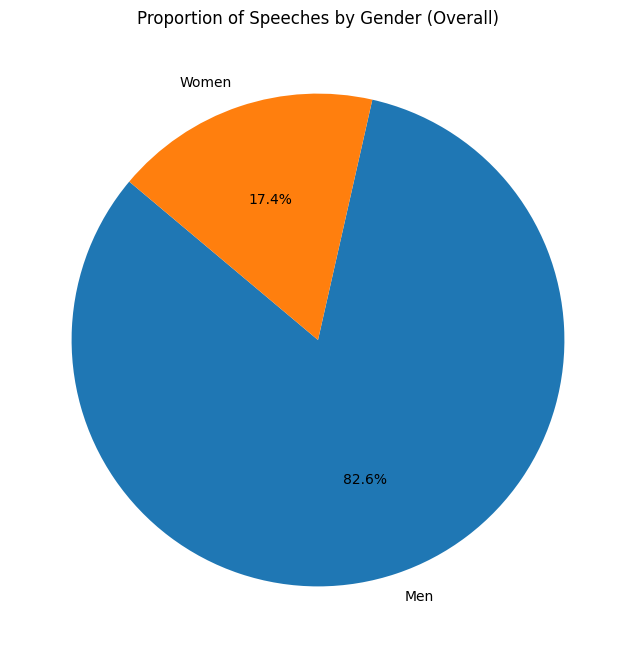

In [97]:
# total count of speeches by gender across the entire dataset
total_gender_counts = speeches['gender'].value_counts()
# rename the index for better labeling
total_gender_counts.index = ['Men' if gender == 'male' else 'Women' for gender in total_gender_counts.index]

# pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    total_gender_counts,
    labels=total_gender_counts.index,
    autopct='%1.1f%%',
    startangle=140,
)
plt.title('Proportion of Speeches by Gender (Overall)')
plt.show()

We observe that women speakers make up less than 20% of the speeches collected. \
This raises questions about statistical validity for the rest of our study: when we compare trends or characteristics between men and women, the smaller sample size for women might lead to less reliable conclusions.

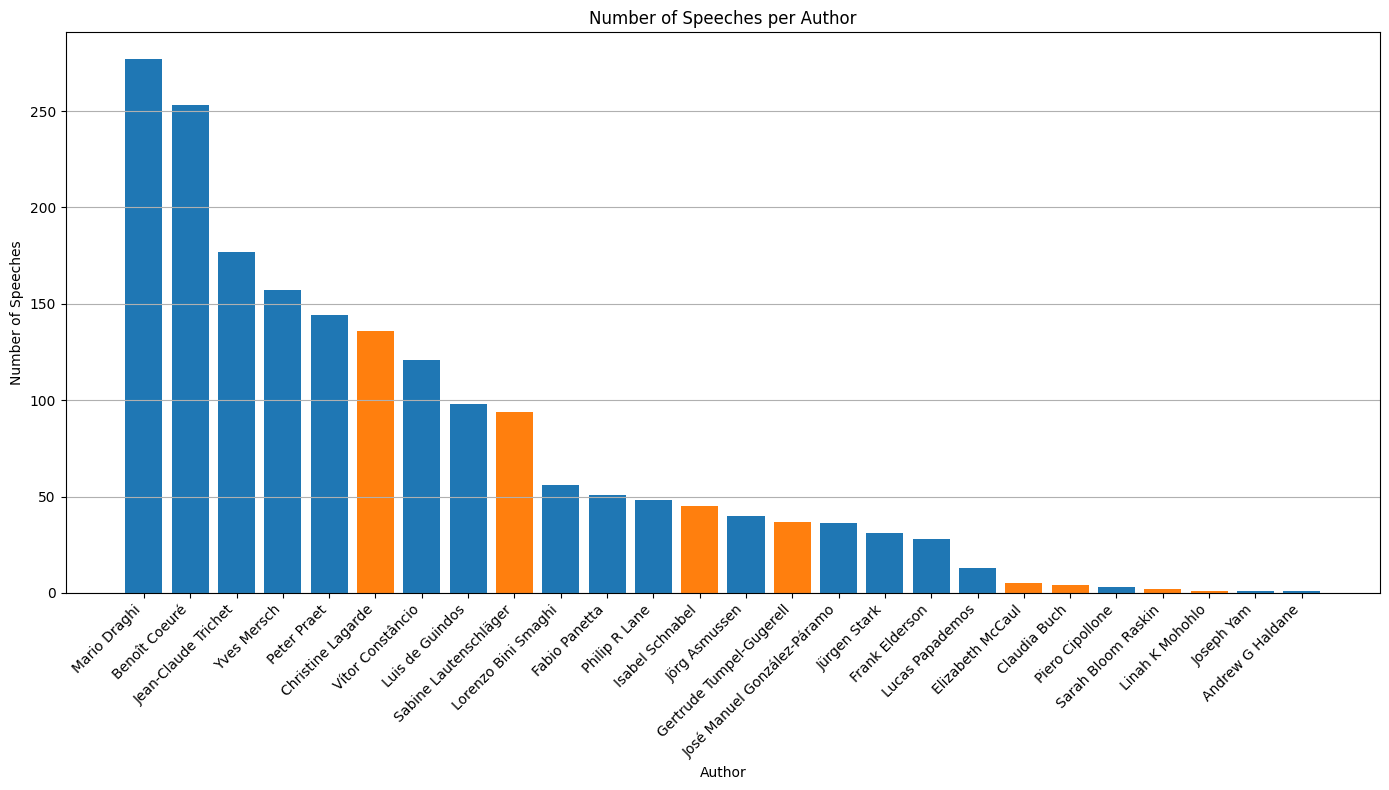

In [113]:
# Count speeches per author
speeches_per_author = speeches['speaker_name'].value_counts()
speeches_per_author = speeches_per_author.rename_axis('speaker_name').reset_index(name='count')

# assign default Matplotlib colors based on gender to match previous colors
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
gender_color_map = {'male': default_colors[0], 'female': default_colors[1], 'unknown': 'gray'}
colors = speeches_per_author['speaker_name'].map(
    lambda name: gender_color_map[fetched_genders[name][0]] if name in fetched_genders else gender_color_map['unknown']
)

# bar chart with colors based on gender
plt.figure(figsize=(14, 8))
plt.bar(speeches_per_author['speaker_name'], speeches_per_author['count'], color=colors)
plt.title("Number of Speeches per Author")
plt.xlabel("Author")
plt.ylabel("Number of Speeches")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


We observe that the top 5 speakers between 2009 and 2024 are men, and only 2 women are in the top 10.

##### Temporal analysis

In [71]:
# Convert 'publication_start_date' to datetime with mixed format handling
# Extract year and month
speeches['converted_date'] = pd.to_datetime(speeches['publication_start_date'], utc=True, format='mixed')
speeches['year'] = speeches['converted_date'].dt.year
speeches['year_month'] = speeches['converted_date'].dt.to_period('M')  # Combines year and month for later graphs

In [72]:
# Plotting speeches per year and speeches per month
speeches_per_year = speeches.groupby('year').size()
speeches_per_month = speeches.groupby('year_month').size()
speeches_per_month.index = speeches_per_month.index.astype(str)  # Convert PeriodIndex to string

# speeches per year
fig_year = px.line(
    x=speeches_per_year.index, 
    y=speeches_per_year.values, 
    labels={'x': 'Year', 'y': 'Number of Speeches'},
    title="Number of Speeches per Year"
)
fig_year.update_traces(mode="lines+markers")
fig_year.update_layout(
    xaxis=dict(title="Year"),
    yaxis=dict(title="Number of Speeches"),
    template="plotly_white"
)
fig_year.show()

# speeches per month
fig_month = px.line(
    x=speeches_per_month.index, 
    y=speeches_per_month.values, 
    labels={'x': 'Year-Month', 'y': 'Number of Speeches'},
    title="Number of Speeches per Month"
)
fig_month.update_traces(mode="lines+markers")
fig_month.update_layout(
    xaxis=dict(
        title="Year-Month",
        tickmode="array",
        tickvals=speeches_per_month.index[::6],  # Show every 6th month
        ticktext=[str(val) for val in speeches_per_month.index[::6]],  # Convert to string
    ),
    yaxis=dict(title="Number of Speeches"),
    template="plotly_white"
)
fig_month.show()


The number of speeches per year is rather heterogenous, with a drop in 2020 and much less speeches in recent years (2020-2024). \
The monthly distribution allows to look for yearly trend in the speeches distribution. We see that, almost every year (exceptions being 2012, 2017 and 2021), the lowest number of speeches per month happens to be in August.

#### Gender representation over time

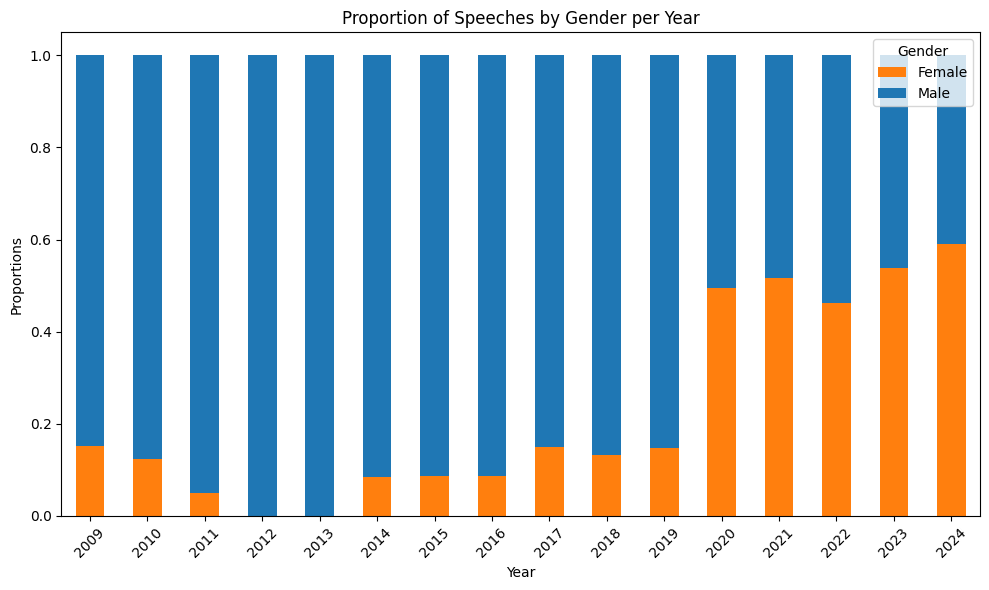

In [114]:
# group by year and gender and count the number of speeches + calculate proportions
gender_counts = speeches.groupby(['year', 'gender']).size().unstack(fill_value=0)
gender_proportions = gender_counts.div(gender_counts.sum(axis=1), axis=0)  # Normalize counts
gender_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), color=[gender_color_map['female'], gender_color_map['male']])

plt.title('Proportion of Speeches by Gender per Year')
plt.xlabel('Year')
plt.ylabel('Proportions')
plt.xticks(rotation=45)
plt.legend(title='Gender', labels=['Female', 'Male'])
plt.tight_layout()
plt.show()

The stacked barplot is very telling of the evolution of the speakers diversity over time : we observe a clear augmentation of women speakers in 2020, which coincides with Christine Lagarde's arrival at the presidence of the BCE. It also coincides with a drop in the total number of speeches per year, men and women alltogether. 

From the previous graph, we also know that Lagarde is the top woman speaker in our dataset.

##### Speeches length analysis

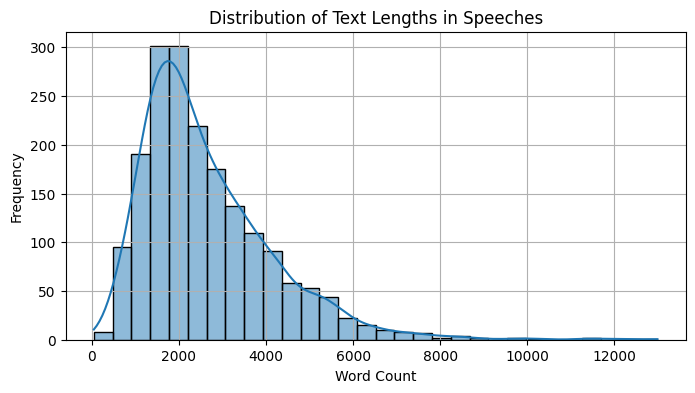

In [19]:
# Word count for each speech
speeches['text_length'] = speeches['speech_content'].apply(lambda x: len(str(x).split()))

# Distribution of text lengths
plt.figure(figsize=(8, 4))
sns.histplot(speeches['text_length'], bins=30, kde=True)
plt.title("Distribution of Text Lengths in Speeches")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram of speech lengths helps to visualize the variability in content richness.

#### Topic exploration
To get a global idea of what topics the speeches treat of

- Word Frequency Analysis and Word Cloud Visualization using word counts and TFIDF Vectorizer

In [117]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Combine all speeches into one text
all_text = " ".join(speeches['speech_content'].dropna())

# Normalize to lowercase and count word frequencies
words = [word.lower() for word in all_text.split()]
word_counts = Counter(words)

# Filter out common stopwords (in english)
stop_words = set(stopwords.words("english"))
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in stop_words}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words="english",
    min_df=15,
    max_df=0.8, # not appear in more than 80% of the doc
    ngram_range=(1, 3),
    token_pattern=r"\b[a-zA-Z]{4,}\b", # removes numbers
)
X_ = vectorizer.fit_transform(speeches["speech_content"].values)
cols = vectorizer.get_feature_names_out()

To reduce the impact over large  `tfidf` coefficients, we use the log transformationl $x \mapsto log(1+x)$ 

In [119]:
tfidf_matrix = X_.toarray() # convert the TF-IDF matrix as a dense array
X_tfidf = pd.DataFrame(np.log1p(tfidf_matrix), index=speeches["speech_content"].index, columns=cols)

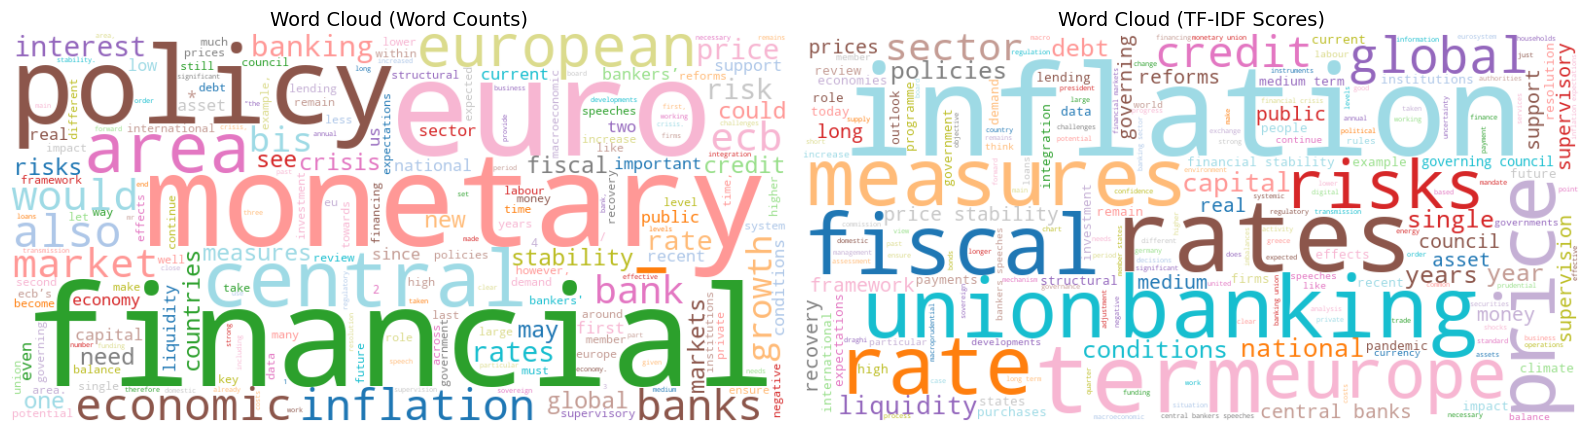

In [127]:
# generate WordCloud according to word counts
wordcloud_counts = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(filtered_word_counts)

# generate WordCloud according to TF-IDF scores
# Calculate the sum of the TF-IDF scores for each term across all speeches
sum_tfidf_scores = tfidf_matrix.sum(axis=0)
# Create a dictionary with words as keys and their total TF-IDF score as values
word_freq = dict(zip(cols, sum_tfidf_scores))
wordcloud_tfidf = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(word_freq)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Word Cloud for Word Counts
axes[0].imshow(wordcloud_counts, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Word Cloud (Word Counts)", fontsize=14)

# Word Cloud for TF-IDF Scores
axes[1].imshow(wordcloud_tfidf, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Word Cloud (TF-IDF Scores)", fontsize=14)

plt.tight_layout()
plt.show()

We represented two word clouds to get a visual insight into which words are most common in the speeches :
1. Word Counts: displays the most frequent words across all speeches in our dataset. This is useful for understanding the key themes or common terms across all speeches, but might include common, less meaningful words that appear frequently.
2. TF-IDF Scores: based on the TF-IDF scores, which measure how important a word is in a document relative to a larger corpus. Words that are more specific to certain documents and less common in the entire dataset will have higher scores (and be shown larger). This is useful to highlight words that are more distinctive or unique to specific speeches, as opposed to general or commonly used words (over multiple speeches). 

By comparing the two word clouds, we get a deeper understanding of both general trends and more context-specific details about the speeches.

### ANALYTICS AND LEARNING STRATEGY

3 : why is it an important question, why does it matter ? (central bank data). What is your contribution, what do you bring ? what has been done and what changes with what I’m doing. What is new in what you’re doing.
Is the evaluation a backtest or something else, …

The analytics and machine learning methodologies section accounts for:

- A detailed explanation of the foundational algorithm.
- A description of the data partitioning strategy for training, validation and test.

- An overview of the parameter selection and optimization process.

### 1. Topic Modeling

##### Preprocess speeches

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
import spacy
# Load a spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# preprocessing function
def preprocess_text(text):
    doc = nlp(text.lower())  # Convert text to lowercase and tokenize
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

speeches['processed_content_topic_modeling'] = speeches['speech_content'].apply(lambda doc: preprocess_text(doc).split())
# 32min
# 40 min

KeyError: "['cleaned_speech_tokens'] not in index"

#### LDA : 
LDA is a generative probabilistic model that assumes documents are mixtures of topics, and topics are mixtures of words.

- with document-term matrix

In [27]:
from gensim import corpora
from gensim.models import LdaModel

# # Create the document-term matrix
dictionary = corpora.Dictionary(speeches['processed_content_topic_modeling'])
doc_term_matrix = [dictionary.doc2bow(doc) for doc in speeches['processed_content_topic_modeling']]

# LDA model
lda = LdaModel(corpus=doc_term_matrix, num_topics=6, id2word = dictionary, passes=10)
topics = lda.print_topics(num_topics=8, num_words=7)
for i, topic in topics:
    print(f"Topic {i}: {topic}")

Topic 0: 0.011*"bank" + 0.010*"european" + 0.010*"euro" + 0.009*"country" + 0.009*"central" + 0.009*"ecb" + 0.007*"europe"
Topic 1: 0.022*"payment" + 0.013*"bank" + 0.011*"market" + 0.010*"euro" + 0.010*"european" + 0.010*"central" + 0.009*"financial"
Topic 2: 0.016*"policy" + 0.016*"rate" + 0.014*"monetary" + 0.013*"euro" + 0.013*"area" + 0.012*"bank" + 0.011*"inflation"
Topic 3: 0.022*"policy" + 0.015*"monetary" + 0.013*"rate" + 0.012*"bank" + 0.011*"financial" + 0.011*"central" + 0.009*"market"
Topic 4: 0.020*"inflation" + 0.014*"policy" + 0.010*"monetary" + 0.009*"area" + 0.009*"rate" + 0.008*"euro" + 0.008*"price"
Topic 5: 0.019*"financial" + 0.017*"bank" + 0.011*"risk" + 0.011*"market" + 0.010*"area" + 0.009*"euro" + 0.009*"european"


Topic 1:
['bank', 'european', 'euro', 'country', 'central', 'ecb', 'europe', 'policy', 'crisis', 'area']



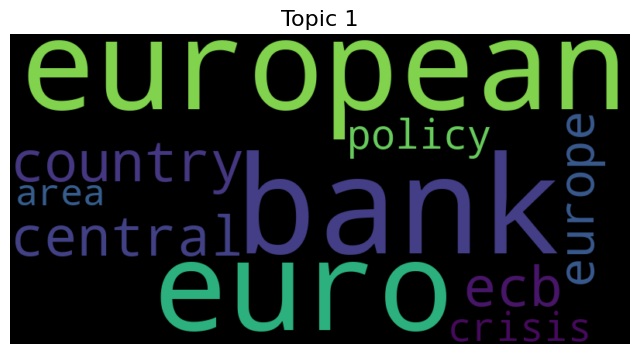

Topic 2:
['payment', 'bank', 'market', 'euro', 'european', 'central', 'financial', 'digital', 'service', 'money']



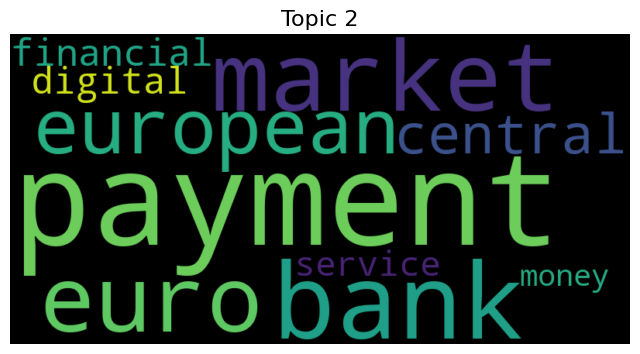

Topic 3:
['policy', 'rate', 'monetary', 'euro', 'area', 'bank', 'inflation', 'price', 'term', 'growth']



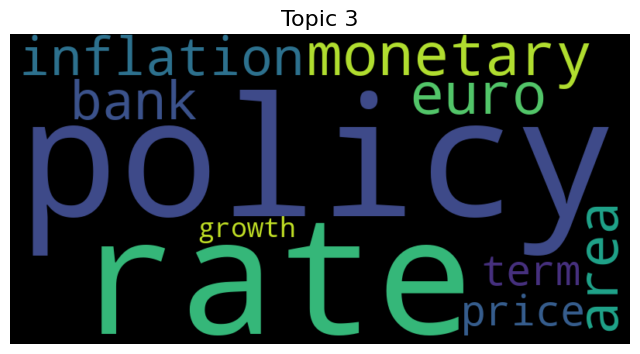

Topic 4:
['policy', 'monetary', 'rate', 'bank', 'financial', 'central', 'market', 'asset', 'ecb', 'economic']



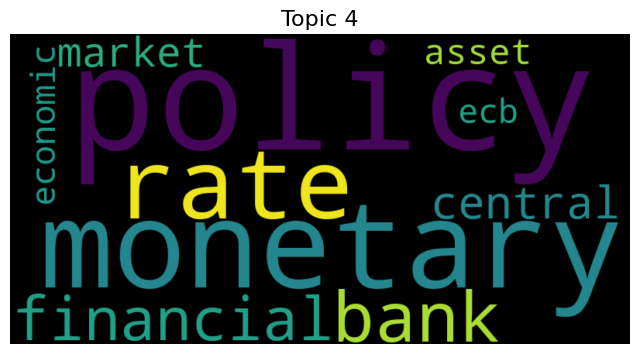

Topic 5:
['inflation', 'policy', 'monetary', 'area', 'rate', 'euro', 'price', 'ecb', 'economic', 'growth']



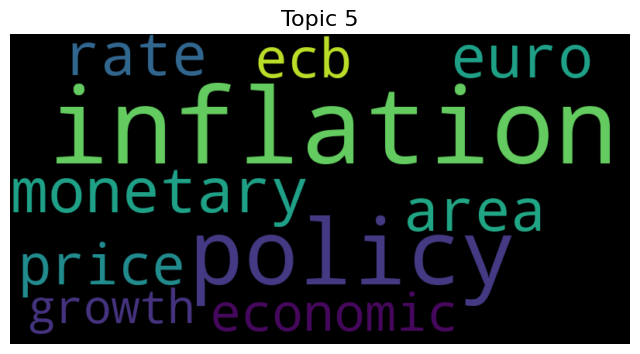

Topic 6:
['financial', 'bank', 'risk', 'market', 'area', 'euro', 'european', 'crisis', 'banking', 'central']



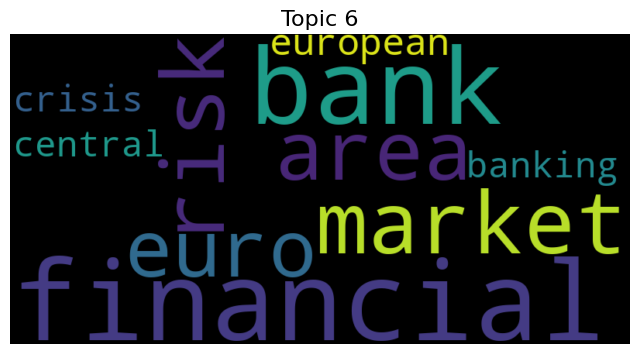

In [28]:
# display the top words + wordcloud for each topic
num_topics = lda.num_topics

for topic_id in range(num_topics):
    # Get the top 10 words for each topic
    top_words = lda.show_topic(topic_id, topn=10)
    print(f"Topic {topic_id + 1}:")
    print([word for word, prob in top_words])  # Extract just the words
    print()

    # wordcloud
    words = dict(lda.show_topic(topic_id, topn=10))  # Get top 20 words for the topic
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(words)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topic {topic_id + 1}", fontsize=16)
    plt.axis("off")
    plt.show()

In [29]:
from gensim.models import CoherenceModel

# Compute coherence score for the LDA model
coherence_model_lda = CoherenceModel(model=lda, texts=speeches['processed_content_topic_modeling'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}")

Coherence Score: 0.3476420265231617


Compare topic "distribution" among genders

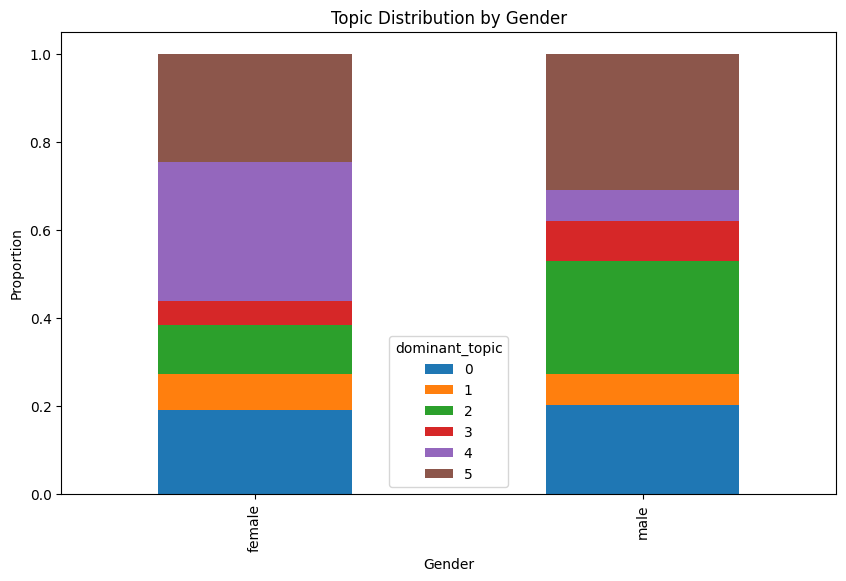

In [30]:
# Assign the dominant topic for each speech
speeches['dominant_topic'] = [max(lda[doc], key=lambda x: x[1])[0] for doc in doc_term_matrix]

# Analyze topic distribution by gender
topic_by_gender = speeches.groupby(['gender', 'dominant_topic']).size().unstack().fillna(0)
topic_by_gender = topic_by_gender.div(topic_by_gender.sum(axis=1), axis=0)

# Plot topic distribution by gender
topic_by_gender.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Topic Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Proportion")
plt.show()


- with TFIDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim.models import LdaModel

# Step 1: Join tokens back into strings for TF-IDF processing
speeches['processed_content_topic_modeling_str'] = speeches['processed_content_topic_modeling'].apply(lambda tokens: ' '.join(tokens))

# Step 2: Generate the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Limit the vocabulary size
tfidf_matrix = tfidf_vectorizer.fit_transform(speeches['processed_content_topic_modeling_str'])

# Step 3: Get the TF-IDF vocabulary
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

# Step 4: Tokenize the documents (re-split strings back into tokens for Gensim)
tokenized_docs = [doc.split() for doc in speeches['processed_content_topic_modeling_str']]

# Step 5: Create a Gensim dictionary
gensim_dictionary = corpora.Dictionary(tokenized_docs)

# Step 6: Map TF-IDF features to Gensim dictionary IDs
# Create a mapping between TF-IDF features and Gensim dictionary IDs
vocab_mapping = {word: gensim_dictionary.token2id[word] for word in tfidf_vocab if word in gensim_dictionary.token2id}

# Step 7: Convert the TF-IDF matrix to Gensim corpus format
gensim_corpus_tfidf = [
    [(vocab_mapping[tfidf_vocab[i]], tfidf_value) for i, tfidf_value in zip(tfidf_matrix.getrow(doc_idx).indices, tfidf_matrix.getrow(doc_idx).data) if tfidf_vocab[i] in vocab_mapping]
    for doc_idx in range(tfidf_matrix.shape[0])
]

# Step 8: Train the LDA model using the TF-IDF-based corpus
lda_tfidf = LdaModel(corpus=gensim_corpus_tfidf, num_topics=8, id2word=gensim_dictionary, passes=10)

# Step 9: Print the topics
topics_tfidf = lda_tfidf.print_topics(num_topics=8, num_words=5)
for i, topic in topics_tfidf:
    print(f"Topic {i}: {topic}")


Topic 0: 0.000*"bank" + 0.000*"euro" + 0.000*"policy" + 0.000*"central" + 0.000*"area"
Topic 1: 0.000*"policy" + 0.000*"euro" + 0.000*"bank" + 0.000*"area" + 0.000*"monetary"
Topic 2: 0.000*"policy" + 0.000*"euro" + 0.000*"monetary" + 0.000*"bank" + 0.000*"inflation"
Topic 3: 0.000*"bank" + 0.000*"financial" + 0.000*"european" + 0.000*"risk" + 0.000*"market"
Topic 4: 0.008*"bank" + 0.008*"policy" + 0.007*"euro" + 0.006*"financial" + 0.006*"area"
Topic 5: 0.000*"bank" + 0.000*"policy" + 0.000*"financial" + 0.000*"monetary" + 0.000*"market"
Topic 6: 0.000*"euro" + 0.000*"bank" + 0.000*"policy" + 0.000*"area" + 0.000*"inflation"
Topic 7: 0.000*"bank" + 0.000*"policy" + 0.000*"financial" + 0.000*"euro" + 0.000*"central"


In [33]:
from gensim.models import CoherenceModel

# Compute coherence score for the LDA model
coherence_model_lda = CoherenceModel(model=lda_tfidf, texts=speeches['processed_content_topic_modeling'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}") # 0.30


Coherence Score: 0.29997230178936957


Coherence is worse so we stick to Document-Text matrix

#### NMF :
group tokens into topics that explain differences across documents

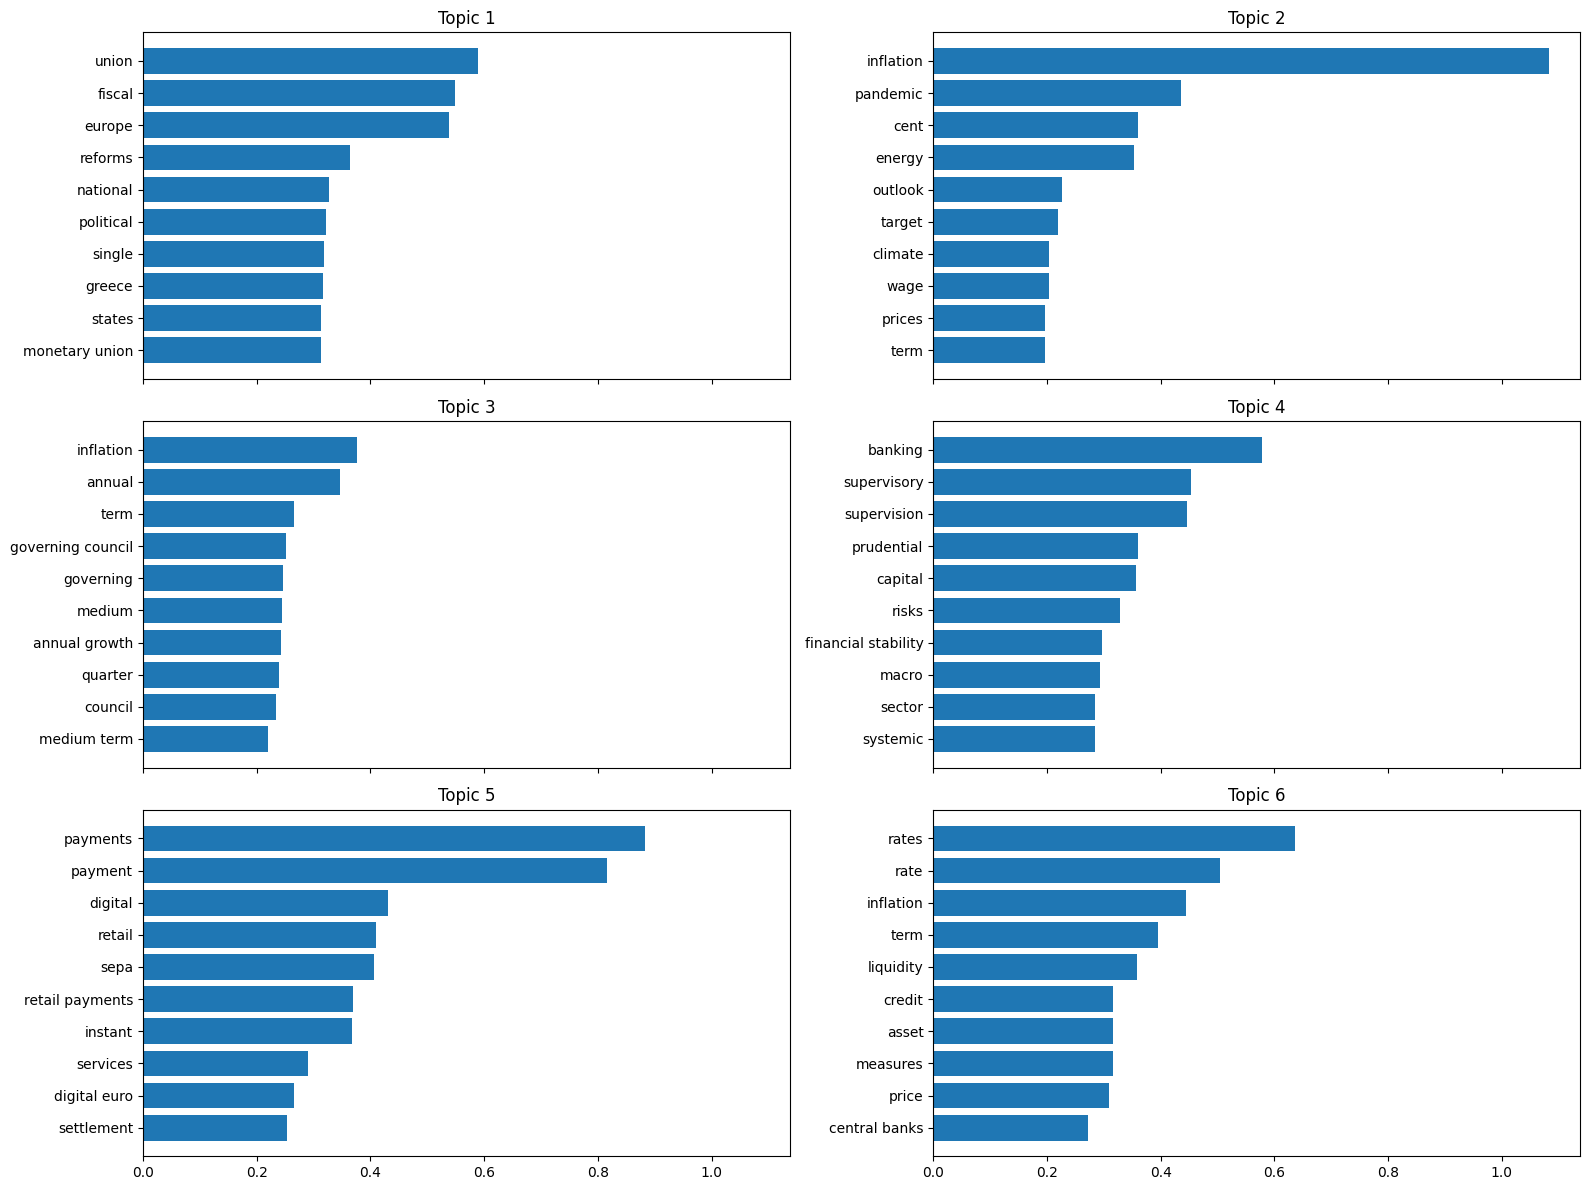

In [34]:
from sklearn.decomposition import NMF

# Initialize the NMF model
nmf = NMF(n_components=6, random_state=42, max_iter=500)

# Fit the model to the data
nmf.fit(X_tfidf)

# Ensure necessary variables are defined correctly
cols = vectorizer.get_feature_names_out()
H2_ = pd.DataFrame(nmf.components_, columns=cols)  # Transpose if required for your use case

# Plot the top words for each topic
n_topics = 6  # Number of topics to display
n_top_words = 10  # Number of top words per topic

fig, axes = plt.subplots(n_topics // 2, 2, figsize=(16, 12), sharex=True)
axes = axes.ravel()

for topic_idx, ax in enumerate(axes[:n_topics]):
    top_words = H2_.iloc[topic_idx].sort_values(ascending=False).head(n_top_words)
    ax.barh(top_words.index, top_words.values)
    ax.set_title(f"Topic {topic_idx + 1}")
    ax.invert_yaxis()  # display the highest value at the top

plt.tight_layout()
plt.show()


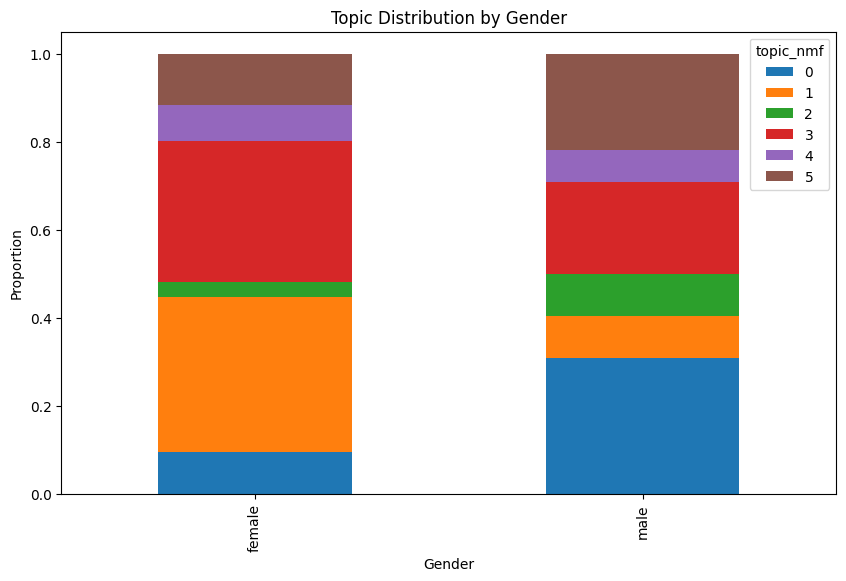

In [35]:
topic_assignments = nmf.transform(X_tfidf)
speeches['topic_nmf'] = topic_assignments.argmax(axis=1) # Assign the dominant topic for each speech

# Analyze topic distribution by gender
topic_by_gender = speeches.groupby(['gender', 'topic_nmf']).size().unstack().fillna(0)
topic_by_gender = topic_by_gender.div(topic_by_gender.sum(axis=1), axis=0)

# Plot topic distribution by gender
topic_by_gender.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Topic Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Proportion")
plt.show()


##### BERTopic

In [51]:
from bertopic import BERTopic

In [52]:
# Initialize the BERTopic model
topic_model = BERTopic()

# Train the model on the speech content
topics, probs = topic_model.fit_transform(speeches['processed_content_topic_modeling_str'])

topic_model.get_topic_info()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,67,-1_euro_policy_ecb_area,"[euro, policy, ecb, area, monetary, european, ...",[christine lagarde imfc statement speech ms ch...
1,0,272,0_euro_area_monetary_policy,"[euro, area, monetary, policy, inflation, grow...",[mario draghi imfc statement statement mr mari...
2,1,214,1_market_bank_euro_rate,"[market, bank, euro, rate, central, policy, ar...",[benoît cœuré monetary policy european central...
3,2,183,2_payment_bank_digital_central,"[payment, bank, digital, central, european, eu...",[01/12/2020 payment revolution reinvention mon...
4,3,143,3_policy_rate_bank_monetary,"[policy, rate, bank, monetary, inflation, cent...",[peter praet monetary policy low interest rate...
5,4,140,4_financial_crisis_trichet_euro,"[financial, crisis, trichet, euro, stability, ...",[jean claude trichet lesson crisis speech mr j...
6,5,117,5_financial_bank_policy_banking,"[financial, bank, policy, banking, market, are...",[vítor constâncio banking union meaning implic...
7,6,89,6_bank_banking_supervisor_risk,"[bank, banking, supervisor, risk, supervisory,...",[sabine lautenschläger year crisis risk rule s...
8,7,78,7_pandemic_inflation_support_continue,"[pandemic, inflation, support, continue, europ...",[christine lagarde ecb press conference introd...
9,8,76,8_bank_financial_area_euro,"[bank, financial, area, euro, sector, policy, ...",[luis de guindos financial stability euro area...


In [53]:
# Display the top 10 words for each topic
for topic in range(len(topic_model.get_topics())):
    print(f"Topic {topic}: {topic_model.get_topic(topic)}")


Topic 0: [('euro', 0.021553620306600237), ('area', 0.021436626365236265), ('monetary', 0.019839987328397916), ('policy', 0.01946815291067466), ('inflation', 0.017374042533049618), ('growth', 0.01620860773716185), ('rate', 0.01555276748301378), ('economic', 0.015265662966555649), ('country', 0.013981490701713485), ('bank', 0.013022282973239008)]
Topic 1: [('market', 0.017767815355991576), ('bank', 0.017362517454885585), ('euro', 0.017192977742022043), ('rate', 0.016617473457355404), ('central', 0.016476380463589336), ('policy', 0.016336551456983633), ('area', 0.01560032731886395), ('monetary', 0.013417718827435081), ('financial', 0.012841299577845418), ('ecb', 0.012837290981273912)]
Topic 2: [('payment', 0.03139085480151994), ('bank', 0.02150587462452142), ('digital', 0.020400407277491768), ('central', 0.01828945230297878), ('european', 0.01634628356445926), ('euro', 0.016137273048881372), ('market', 0.01599231015329173), ('service', 0.013231794497987866), ('financial', 0.01302483168937

In [54]:
topic_model.visualize_topics()

### 2. Sentiment Analysis

#### 1st approach : Loughran-McDonals sentiment lexicon
English sentiment lexicon created for use with financial documents. This lexicon labels words with six possible sentiments important in financial contexts: "negative", "positive", "litigious", "uncertainty", "constraining", or "superfluous".

We want to lead two distinct analysis : 
- Topic Modeling by Gender, using Latent Dirichlet Allocation (LDA) technique and NMF? to identify dominant topics in speeches by men and women.
- Sentiment Analysis by Gender, using Loughran McDonald's to examine sentiment /tone differences for both genders

In [36]:
# from skfin.plot import line
# from skfin.text import coefs_plot, show_text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [37]:
logger = logging.getLogger(__name__)

def load_loughran_mcdonald_dictionary(cache_dir="data", force_reload=False):
    """
    Loads the Loughran-McDonald Master Dictionary.
    If the file doesn't exist locally, downloads it from the external source.
    
    Parameters:
        cache_dir (str): Directory to cache the file.
        force_reload (bool): Whether to force downloading the file again.
    
    Returns:
        pd.DataFrame: Loaded dictionary as a DataFrame.
    """
    # Ensure the cache directory exists
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    
    # Filepath for the dictionary
    filename = cache_dir / "Loughran-McDonald_MasterDictionary_1993-2021.csv"
    
    if filename.exists() and not force_reload:
        logger.info(f"Loading from cache file: {filename}")
    else:
        logger.info("Loading from external source")
        id = "17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik"
        url = f"https://docs.google.com/uc?export=download&id={id}"
        
        try:
            # Download file using requests
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Raise an error for bad HTTP status codes
            
            with open(filename, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            logger.info(f"Downloaded file to {filename}")
        except requests.RequestException as e:
            logger.error(f"Error downloading file: {e}")
            raise
    
    # Ensure the file exists after the operation
    if not filename.exists():
        raise FileNotFoundError(f"Failed to download file: {filename}")
    
    # Load the CSV file into a DataFrame
    return pd.read_csv(filename)

lm = load_loughran_mcdonald_dictionary()

In [38]:
# Filter the dictionary for relevant sentiment categories
sentiment_categories = ['Positive', 'Negative', 'Uncertainty', 'Litigious', 'Constraining']
lm_sentiment_words = lm[['Word'] + sentiment_categories].set_index('Word').fillna(0)

In [39]:
X_men = speeches_men['speech_content']
X_women = speeches_women['speech_content']
funcs = {
    "negative": lambda x: x.Negative > 0,
    "positive": lambda x: x.Positive > 0,
    "all": lambda x: x.Word.notna(),
}

def get_total_count(X, lm, func):
    m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)


lm_counts_men = pd.concat({k: get_total_count(X_men, lm, v) for k, v in funcs.items()}, axis=1)
lm_counts_women = pd.concat({k: get_total_count(X_women, lm, v) for k, v in funcs.items()}, axis=1)

C:\Users\marie\AppData\Local\Temp\ipykernel_17020\1954524431.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




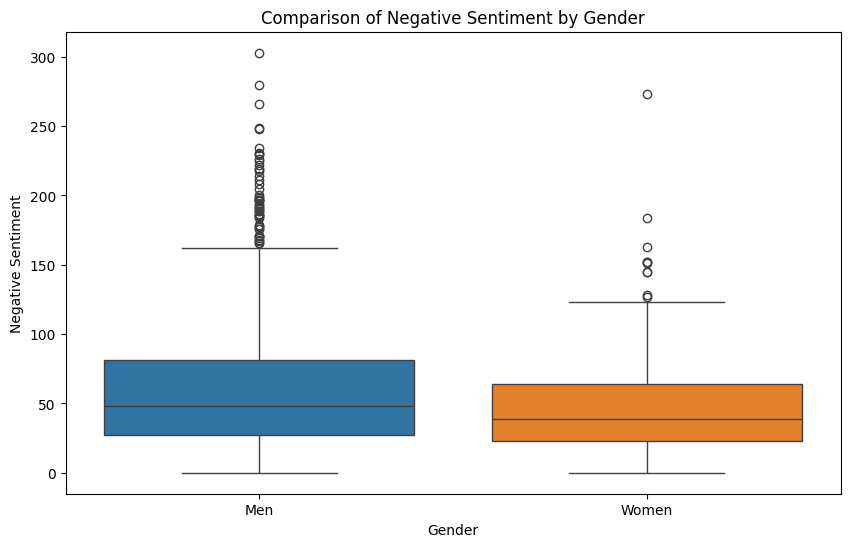

C:\Users\marie\AppData\Local\Temp\ipykernel_17020\1954524431.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




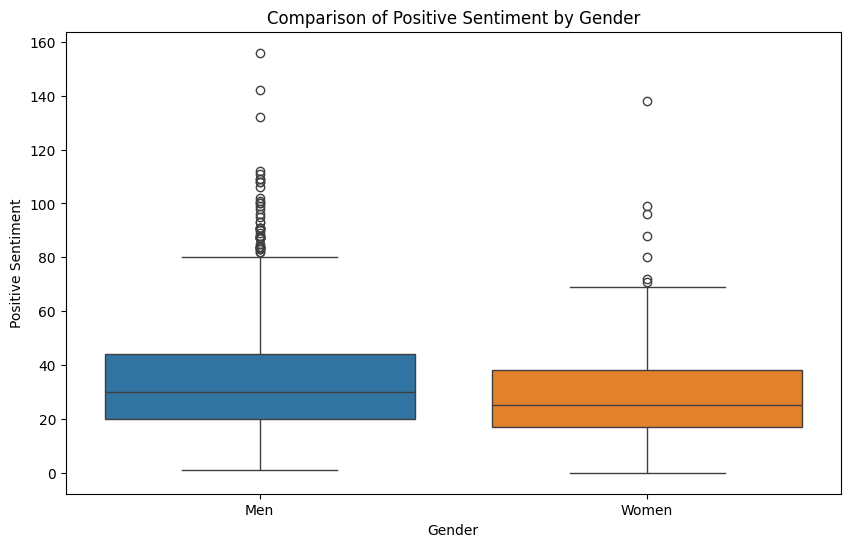

In [40]:
lm_counts_men['date'] = pd.to_datetime(speeches_men['converted_date'])
lm_counts_men = lm_counts_men.set_index('date')
lm_counts_women['date'] = pd.to_datetime(speeches_women['converted_date'])
lm_counts_women = lm_counts_women.set_index('date')
lm_counts_men['gender'] = 'Men'
lm_counts_women['gender'] = 'Women'
lm_counts_combined = pd.concat([lm_counts_men, lm_counts_women])

# Negative
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='negative', data=lm_counts_combined, palette="tab10")
plt.title("Comparison of Negative Sentiment by Gender")
plt.xlabel("Gender")
plt.ylabel("Negative Sentiment")
plt.show()

# Positive
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='positive', data=lm_counts_combined, palette="tab10")
plt.title("Comparison of Positive Sentiment by Gender")
plt.xlabel("Gender")
plt.ylabel("Positive Sentiment")
plt.show()


Men : higher median in both negative and postive sentiments : Men's speeches are more emotionally charged, men’s speeches may cover a wider emotional spectrum, reflecting a tendency to express contrasting sentiments more frequently or strongly.

A higher median for negative sentiment suggests men might be more critical, pessimistic, or focused on challenges in their speeches.
A higher median for positive sentiment implies they may also emphasize optimism or solutions more often.
Men might adopt a more assertive or persuasive tone, which could involve emphasizing both problems and resolutions more explicitly.


In [41]:
# Filter speeches after 2020 for better readability
date_filter = "2023-01-01" #"2020-01-01"
lm_counts_men_filtered = lm_counts_men[lm_counts_men.index >= date_filter]
lm_counts_women_filtered = lm_counts_women[lm_counts_women.index >= date_filter]

# Calculate sentiment score for women and men after 2020
sentiment_women = (
    lm_counts_women_filtered.pipe(lambda x: (x.positive - x.negative) / x["all"])
    .resample("B")
    .last()
    .ffill()
)
sentiment_men = (
    lm_counts_men_filtered.pipe(lambda x: (x.positive - x.negative) / x["all"])
    .resample("B")
    .last()
    .ffill()
)

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=["Sentiment Over Time (After 2020): Men", "Sentiment Over Time (After 2020): Women"],
)

# Men's sentiment
fig.add_trace(
    go.Scatter(
        x=sentiment_men.index,
        y=sentiment_men,
        mode='lines+markers',
        name="Men's Sentiment",
        line=dict(color='blue', width=1.5),
        marker=dict(size=4),
        showlegend=False,
    ),
    row=1, col=1
)
# Women's sentiment
fig.add_trace(
    go.Scatter(
        x=sentiment_women.index,
        y=sentiment_women,
        mode='lines+markers',
        name="Women's Sentiment",
        line=dict(color='red', width=1.5),
        marker=dict(size=4),
        showlegend=False
    ),
    row=2, col=1
)

fig.update_layout(
    title="Sentiment Analysis Over Time (After 2020)",
    yaxis_title="Sentiment Score",
    xaxis=dict(showgrid=True, tickangle=45),
    yaxis=dict(showgrid=True),
    template="plotly_white",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.show()


For better readability, we focus on the 2020-2024 period, which is also th eperiod where the amount of men vswomen speeches is more equilibré. 

2nd approach : There are few transformers algo to treat sentiment analysis for long texts 

longformer

In [42]:
from transformers import LongformerTokenizer
from transformers import pipeline

# Initialize the tokenizer for Longformer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
# Load Longformer for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model="allenai/longformer-base-4096")

# # Apply tokenization to processed speech content
# speeches['longformer_tokens'] = speeches['processed_content_topic_modeling_str'].apply(lambda x: len(tokenizer.encode(x)))

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# View speeches with token length greater than 4096
speeches['processed_content_topic_modeling_length'] = speeches['processed_content_topic_modeling'].apply(len)
long_speeches = speeches[speeches['processed_content_topic_modeling_length'] > 4096]
# Count how many such speeches exist
print(f"Number of speeches longer than 4096 tokens: {len(long_speeches)}")
# long_speeches['processed_content_topic_modeling_length']
# truncate those to fit the model
max_length = 4096
speeches['processed_content_topic_modeling'] = speeches['processed_content_topic_modeling'].apply(
    lambda tokens: tokens[:max_length] if len(tokens) > max_length else tokens)

Number of speeches longer than 4096 tokens: 26


In [ ]:
# Apply sentiment analysis
# speeches['sentiment_longformer'] = speeches['processed_content_topic_modeling'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

Initializing global attention on CLS token...
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


KeyboardInterrupt: 

In [ ]:
# print(speeches['sentiment_longformer'].unique())
# # Count sentiment frequencies
# sentiment_counts = speeches['sentiment_longformer'].value_counts()
# sentiment_counts

KeyError: 'sentiment_longformer'

 a long and structured text may probably contain segments of "positive" sentiment along with "negative" ones, it can be infinitely more subtle and nuanced, and in principle trying to simply label it overall as "positive/negative" (or even adding a couple more sentiment categories) is futile, unproductive, and at the end of the day hardly useful.

 If you read a long text, there might be several different subjects and several different sentiments about each subject to be estimated.

### EMPIRICAL RESULTS : BASELINE AND ROBUSTNESS

To effectively convey the empirical findings, separate the baseline results from the additional robustness tests. Within the primary empirical outcomes portion, include:

- Key statistical evaluations (for instance, if presenting a backtest – provide a pnl graph alongside the Sharpe ratio).

- Insights into what primarily influences the results, such as specific characteristics or assets that significantly impact performance.

The robustness of empirical tests section should detail:

- Evaluation of the stability of the principal finding against variations in hyperparameters or algorithmic modifications.

##### Sensitivity tests :
- Number of topics

In [ ]:
# from gensim.models import CoherenceModel
# import matplotlib.pyplot as plt

def evaluate_coherence(dictionary, doc_term_matrix, texts, num_topics_range, passes=10):
    coherence_scores = []
    for num_topics in num_topics_range:
        # Train LDA model
        lda_model = LdaModel(corpus=doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=passes)
        
        # Compute coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
    
    return coherence_scores

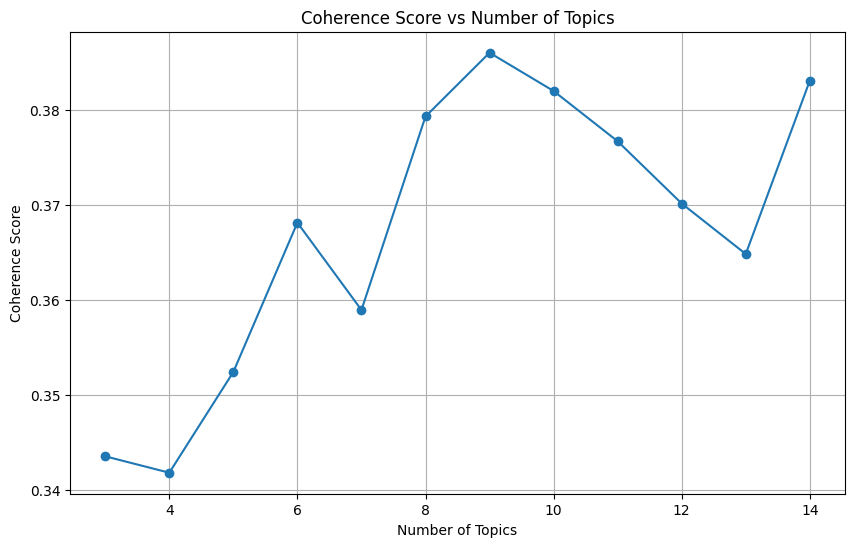

In [ ]:
# Define the range of topics to evaluate
num_topics_range = range(3, 15)

# Evaluate coherence scores for different numbers of topics
coherence_scores = evaluate_coherence(dictionary, doc_term_matrix, speeches['processed_content_topic_modeling'], num_topics_range, passes=20)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()
# 94min

Topic 1:
['climate', 'green', 'change', 'energy', 'policy', 'transition', 'price', 'ecb', '2022', '2021']



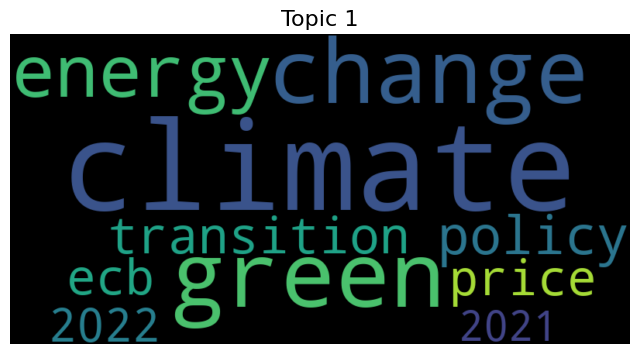

Topic 2:
['policy', 'economic', 'area', 'economy', 'euro', 'growth', 'global', 'monetary', 'international', 'country']



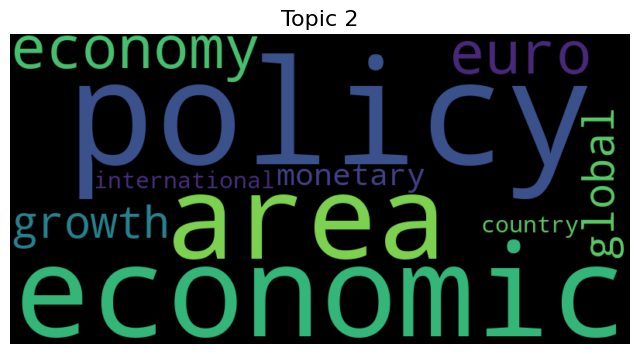

Topic 3:
['payment', 'market', 'bank', 'central', 'financial', 'euro', 'european', 'digital', 'service', 'ccp']



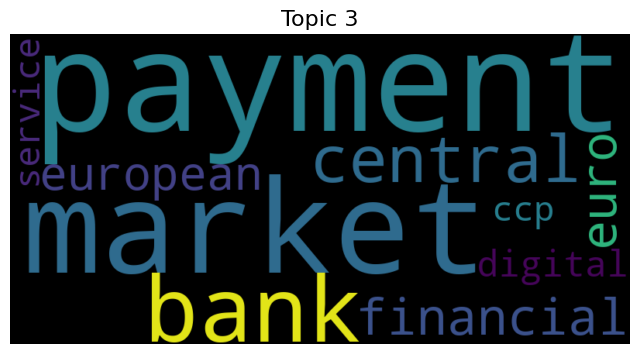

Topic 4:
['bank', 'risk', 'financial', 'banking', 'european', 'central', 'supervisory', 'ecb', 'supervision', 'need']



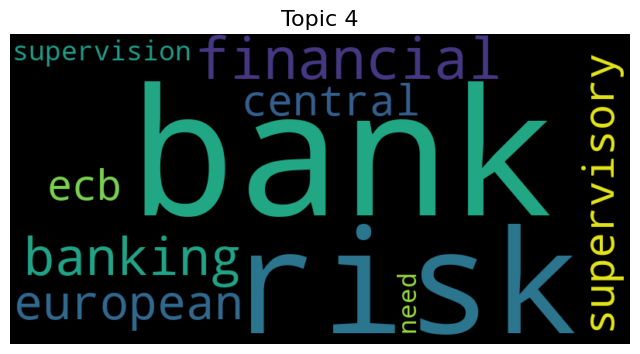

Topic 5:
['euro', 'european', 'country', 'area', 'central', 'policy', 'ecb', 'europe', 'bank', 'crisis']



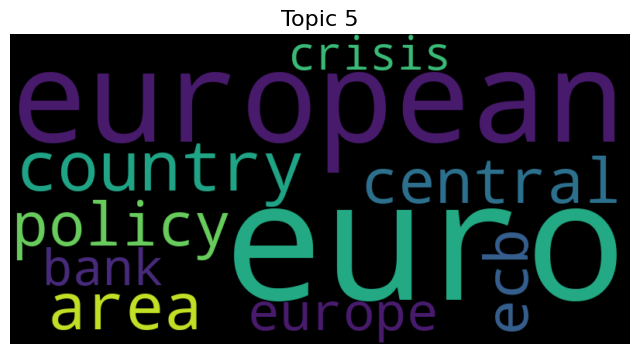

Topic 6:
['inflation', 'policy', 'rate', 'monetary', 'euro', 'area', 'price', 'growth', 'term', 'remain']



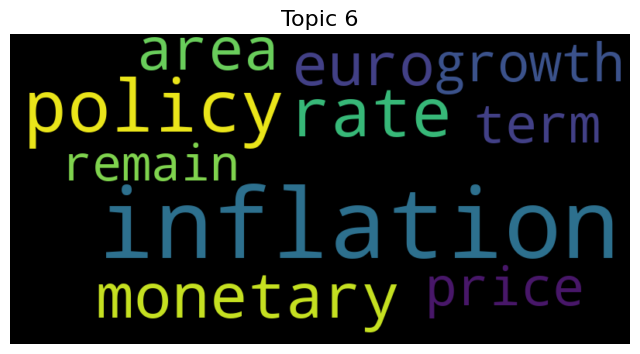

Topic 7:
['euro', 'area', 'economic', 'monetary', 'policy', 'growth', 'financial', 'price', 'fiscal', 'term']



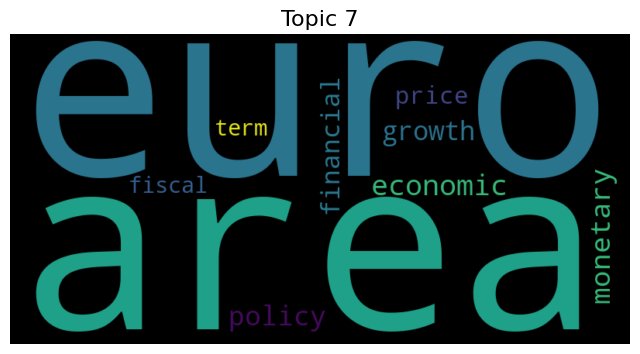

Topic 8:
['policy', 'rate', 'monetary', 'bank', 'central', 'market', 'interest', 'term', 'ecb', 'price']



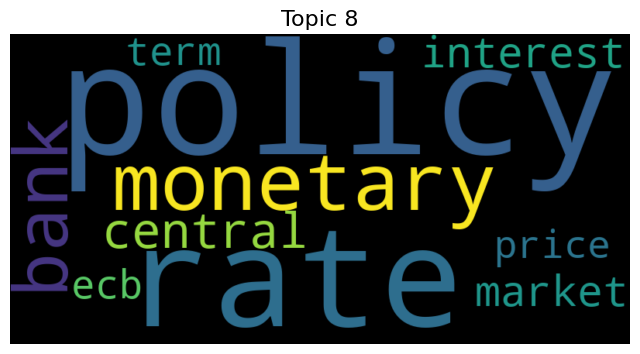

Topic 9:
['financial', 'bank', 'crisis', 'risk', 'market', 'system', 'sector', 'policy', 'credit', 'banking']



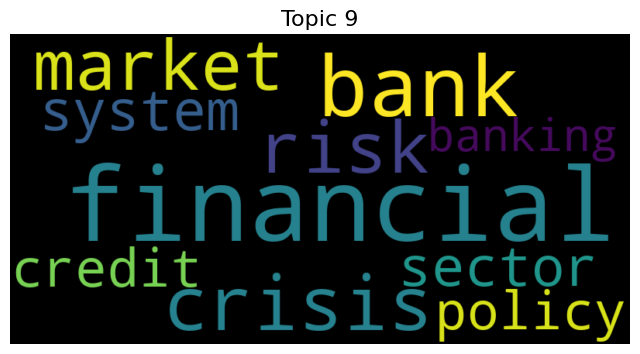

In [58]:
# Show results
best_num_topics = 9
lda = LdaModel(corpus=doc_term_matrix, num_topics=best_num_topics, id2word=dictionary, passes=20)

# display the top words + wordcloud for each topic
num_topics = lda.num_topics

for topic_id in range(num_topics):
    # Get the top 10 words for each topic
    top_words = lda.show_topic(topic_id, topn=10)
    print(f"Topic {topic_id + 1}:")
    print([word for word, prob in top_words])  # Extract just the words
    print()

    # wordcloud
    words = dict(lda.show_topic(topic_id, topn=10))  # Get top 20 words for the topic
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(words)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topic {topic_id + 1}", fontsize=16)
    plt.axis("off")
    plt.show()

- Number of passes (evaluate how varying the passes parameter affects the coherence score.)

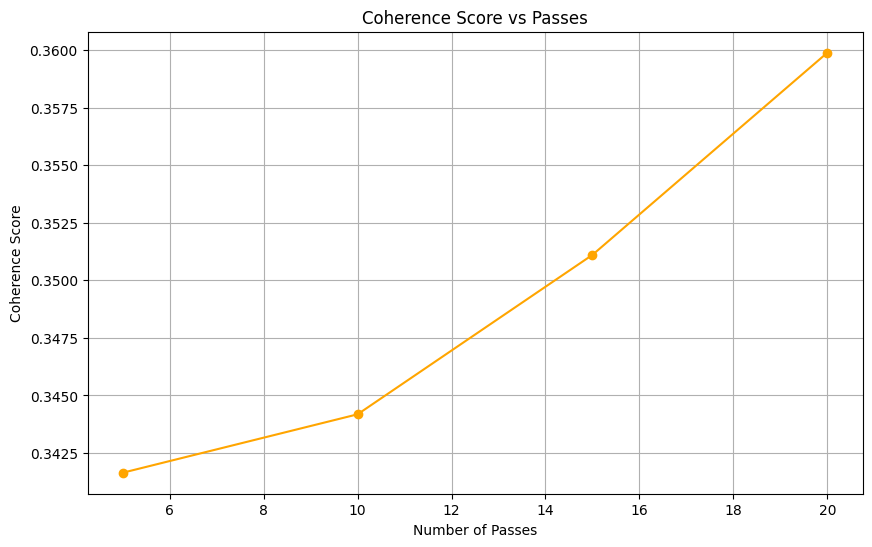

In [55]:
# Define a fixed number of topics and vary passes
passes_range = range(5, 21, 5)
num_topics = 8  # Choose a fixed number of topics

coherence_scores_passes = []
for passes in passes_range:
    lda_model = LdaModel(corpus=doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=passes)
    coherence_model = CoherenceModel(model=lda_model, texts=speeches['processed_content_topic_modeling'], dictionary=dictionary, coherence='c_v')
    coherence_scores_passes.append(coherence_model.get_coherence())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(passes_range, coherence_scores_passes, marker='o', color='orange')
plt.title('Coherence Score vs Passes')
plt.xlabel('Number of Passes')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()


Analyze Results
Optimal Number of Topics: The number of topics with the highest coherence score is likely the best fit for your data.
Passes Stability: Evaluate whether increasing passes improves or stabilizes the coherence score.

- With Grid Search 

In [ ]:
results = []
for num_topics in num_topics_range:
    for passes in passes_range:
        lda_model = LdaModel(corpus=doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=passes)
        coherence_model = CoherenceModel(model=lda_model, texts=speeches['processed_content_topic_modeling'], dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        results.append((num_topics, passes, coherence_score))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['num_topics', 'passes', 'coherence_score'])
print(results_df)

In [ ]:
pivot_table = results_df.pivot(index='num_topics', columns='passes', values='coherence_score')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Coherence Score'})
plt.title("Coherence Scores for Num Topics and Passes")
plt.xlabel("Number of Passes")
plt.ylabel("Number of Topics")
plt.show()


### CONCLUSION

Finally, the conclusive synthesis should recapitulate the primary findings, consider external elements that may influence the results, and hint at potential directions for further investigative work.

Custom Sentiment Models: Fine-tune a transformer model like BERT on a labeled dataset specific to central bank language.

improvements : use LLMs to detect intention, sentiment ...

Actions:
Focus on Gender Differences in Sentiment Analysis:
Group the speeches by speaker gender (if metadata is available).
Calculate sentiment scores (using tools like VADER or TextBlob) and analyze distributions across genders.
Hypothesis Testing:
Formulate hypotheses, e.g., "Do male and female central bankers use different tones during economic crises?"
Validate them using statistical tests or machine learning models.


Task 3: Defining Research Objectives
Clarify Gender-Specific Sentiment Analysis:

Define how you will evaluate gender differences in sentiment. For example:
Compare sentiment scores between male and female speakers.
Examine if certain themes are more positively/negatively discussed by a specific gender.
Select Sentiment Analysis Tool:

Choose a sentiment analysis model or library (e.g., VADER, Hugging Face models).
Ensure it can handle the language used in central bank speeches.
Create a Hypothesis:

Draft testable hypotheses related to gender differences in sentiment.
E.g., "Speeches by female speakers will exhibit higher positive sentiment in discussing inclusive economic policies compared to male speakers."
Plan Statistical Tests:

Identify statistical tests (e.g., t-tests, ANOVA) to validate hypotheses.
Consider visualizations (e.g., boxplots, histograms) to support findings.